<a href="https://colab.research.google.com/github/KickDirtBaseball/register/blob/master/Updated_Framing_Leaderboard2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybaseball --upgrade
from pybaseball import statcast
import pandas as pd
from joblib import load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 42.9 MB/s eta 0:00:00


In [3]:
# 2025 April example — adjust as needed
df = statcast(start_dt="2025-04-01", end_dt="2025-04-30")

This is a large query, it may take a moment to complete


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = d

In [4]:
df = df[df['description'].isin(['called_strike', 'ball'])].copy()
df = df[df['player_name'].notna()]
df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)
df['hand_matchup'] = df['p_throws'] + '_' + df['stand']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"

framing_model = load(model_path)
preprocessor = load(preprocessor_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
features = [
    'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'zone',
    'release_extension', 'release_pos_x', 'release_pos_z', 'release_speed',
    'pitch_type', 'hand_matchup', 'count', 'stand', 'p_throws'
]

df = df.dropna(subset=features)
X = preprocessor.transform(df[features])
df['strike_prob'] = framing_model.predict_proba(X)[:, 1]
df['is_strike'] = (df['description'] == 'called_strike').astype(int)
df['framing_value'] = df['is_strike'] - df['strike_prob']

In [9]:
# Only include pitches where the player was the *catcher*
catchers_only = df[df['player_position'] == 2].copy()

# Re-run the leaderboard using only catchers
leaderboard = (
    catchers_only.groupby('player_name')
    .agg(
        total_pitches=('framing_value', 'count'),
        total_value=('framing_value', 'sum'),
        value_per_100=('framing_value', lambda x: 100 * x.sum() / len(x))
    )
    .sort_values('value_per_100', ascending=False)
    .reset_index()
)

leaderboard.head(15)

KeyError: 'player_position'

In [10]:
# Filter out rows with missing values
df = df.dropna(subset=['framing_value', 'player_name'])

# Optional: Filter to shadow zone only (if applicable)
# df = df[df['zone'].isin([11, 12, 13, 14, 16, 17, 18, 19])]

# Build the leaderboard
leaderboard = (
    df.groupby('player_name')
    .agg(
        total_pitches=('framing_value', 'count'),
        total_framing_value=('framing_value', 'sum'),
        framing_per_100=('framing_value', lambda x: 100 * x.sum() / len(x))
    )
    .query("total_pitches >= 100")  # Filter to real volume
    .sort_values('framing_per_100', ascending=False)
    .reset_index()
)

leaderboard.head(20)

,player_name,total_pitches,total_framing_value,framing_per_100
0,"Cruz, Fernando",118,3.81,3.228814
1,"Buehler, Walker",233,7.49,3.214592
2,"Englert, Mason",109,3.21,2.944954
3,"Lawrence, Casey",111,3.15,2.837838
4,"Nelson, Ryne",134,3.64,2.716418
5,"Ginn, J.T.",139,3.56,2.561151
6,"Spence, Mitch",123,3.08,2.504065
7,"Berríos, José",246,5.70,2.317073
8,"Quantrill, Cal",196,4.45,2.270408
9,"Hart, Kyle",138,2.98,2.159420


In [11]:
df.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,count,hand_matchup,strike_prob,is_strike,framing_value
2793,ST,2025-04-30,86.8,-1.93,5.69,"Svanson, Matt",668715,694335,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,1-1,R_R,0.15,0,-0.15
2893,SI,2025-04-30,96.2,-1.64,5.7,"Svanson, Matt",668715,694335,NaN,called_strike,...,<NA>,<NA>,<NA>,<NA>,<NA>,1-0,R_R,0.98,1,0.02
3000,FC,2025-04-30,90.5,-1.58,5.8,"Svanson, Matt",668715,694335,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,0-0,R_R,0.02,0,-0.02


In [13]:
leaderboard = (
    df.groupby('player_name')
    .agg(
        total_pitches=('framing_value', 'count'),
        total_framing_value=('framing_value', 'sum'),
    )
    .assign(
        framing_per_1000=lambda x: x['total_framing_value'] / x['total_pitches'] * 1000
    )
    .sort_values('framing_per_1000', ascending=False)
    .reset_index()
)

# Round for cleaner display
leaderboard['total_framing_value'] = leaderboard['total_framing_value'].round(2)
leaderboard['framing_per_1000'] = leaderboard['framing_per_1000'].round(2)

# Show top 20 catchers
leaderboard.head(20)

,player_name,total_pitches,total_framing_value,framing_per_1000
0,"Hedges, Austin",19,3.30,173.68
1,"Koss, Christian",2,0.30,150.00
2,"Guerrero, Luis",13,1.02,78.46
3,"Schultz, Paxton",58,4.55,78.45
4,"Wilson, Will",15,1.16,77.33
5,"Hill, Jaden",29,1.79,61.72
6,"Alexander, Jason",27,1.65,61.11
7,"Wiles, Nathan",8,0.46,57.50
8,"Leiter Jr., Mark",92,4.92,53.48
9,"Bowlan, Jonathan",11,0.54,49.09


In [15]:
# Example list of actual catcher names
catcher_names = ['Logan O’Hoppe', 'Austin Wells', 'Yainer Diaz', 'Bo Naylor', 'Shea Langeliers']  # etc.

leaderboard = (
    df[df['player_name'].isin(catcher_names)]
    .groupby('player_name')
    .agg(
        total_pitches=('framing_value', 'count'),
        total_framing_value=('framing_value', 'sum'),
    )
    .assign(
        framing_per_1000=lambda x: x['total_framing_value'] / x['total_pitches'] * 1000
    )
    .sort_values('framing_per_1000', ascending=False)
    .reset_index()
)

leaderboard.head(20)

,player_name,total_pitches,total_framing_value,framing_per_1000


In [16]:
df['player_name'].dropna().unique().tolist()

['Svanson, Matt',
 'Díaz, Alexis',
 'Romero, JoJo',
 'Barlow, Scott',
 'Leahy, Kyle',
 'Rogers, Taylor',
 'Mikolas, Miles',
 'Singer, Brady',
 'Graceffo, Gordon',
 'Richardson, Lyon',
 'Suter, Brent',
 'Matz, Steven',
 'Petty, Chase',
 'Hernández, Carlos',
 'Salazar, Eduardo',
 'Banks, Tanner',
 'Poche, Colin',
 'Irvin, Jake',
 'Ruiz, José',
 'Sánchez, Cristopher',
 'Thompson, Ryan',
 'Martinez, Justin',
 'Devenski, Chris',
 'Miller, Shelby',
 'Ginkel, Kevin',
 'Beeks, Jalen',
 'Stanek, Ryne',
 'Waddell, Brandon',
 'Burnes, Corbin',
 'Brazobán, Huascar',
 'Clase, Emmanuel',
 'Coulombe, Danny',
 'Gaddis, Hunter',
 'Stewart, Brock',
 'López, Pablo',
 'Smith, Cade',
 'Ortiz, Luis L.',
 'Bautista, Félix',
 'Leiter Jr., Mark',
 'Baker, Bryan',
 'Williams, Devin',
 'Soto, Gregory',
 'Cano, Yennier',
 'Akin, Keegan',
 'Cruz, Fernando',
 'Hill, Tim',
 'Domínguez, Seranthony',
 'Povich, Cade',
 'Carrasco, Carlos',
 'Slaten, Justin',
 'Hoffman, Jeff',
 'Chapman, Aroldis',
 'Whitlock, Garrett',
 

In [17]:
# Example: map fielder_2 to name
id_to_name = {
    123456: 'Logan O’Hoppe',
    234567: 'Cal Raleigh',
    # add more here...
}
df['catcher_name'] = df['fielder_2'].map(id_to_name)

In [18]:
df['predicted_strike_prob'] = framing_model.predict_proba(X_transformed)[:, 1]

NameError: name 'X_transformed' is not defined

In [19]:
from joblib import load

# Paths (adjust as needed)
csv_path = "/content/drive/MyDrive/YOUR_FILE.csv"
model_path = "/content/drive/MyDrive/framing_model_2025.joblib"
preprocessor_path = "/content/drive/MyDrive/framing_model_preprocessor_2025V.04.joblib"

# Load data
df = pd.read_csv(csv_path)

# Load model + preprocessor
framing_model = load(model_path)
preprocessor = load(preprocessor_path)

# === Step 1: Select model input columns (must match training!)
input_columns = [
    'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'balls', 'strikes',
    'pitch_type', 'pitcher', 'batter', 'stand', 'p_throws'
    # Add/remove features based on your model
]

# Drop rows with missing inputs
df_model = df.dropna(subset=input_columns)

# === Step 2: Preprocess features
X_transformed = preprocessor.transform(df_model[input_columns])

# === Step 3: Predict with model
df_model['predicted_strike_prob'] = framing_model.predict_proba(X_transformed)[:, 1]

# === Step 4: Calculate framing value
df_model['is_strike'] = df_model['description'].isin(['called_strike']).astype(int)
df_model['framing_value'] = df_model['is_strike'] - df_model['predicted_strike_prob']

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/YOUR_FILE.csv'

In [20]:
from pybaseball import statcast
import pandas as pd
from datetime import datetime

start_date = "2025-03-20"
end_date = datetime.today().strftime("%Y-%m-%d")

# Pull Statcast data
statcast_data = statcast(start_date, end_date)
statcast_data.to_csv("/content/2025_statcast.csv", index=False)

# Preview
statcast_data.head()

This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/86 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_cop

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3288,SI,2025-06-11,97.2,1.94,5.55,"Soto, Gregory",672761,642397,field_out,hit_into_play,...,<NA>,1.99,1.6,-1.6,<NA>,14.279219,-6.644513,30.825621,31.421513,31.374625
3429,SI,2025-06-11,95.4,1.92,5.69,"Soto, Gregory",672761,642397,NaN,called_strike,...,<NA>,2.06,1.62,-1.62,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3543,FF,2025-06-11,97.3,1.75,5.69,"Soto, Gregory",679529,642397,strikeout,swinging_strike,...,<NA>,1.29,0.89,-0.89,<NA>,-12.240506,39.260756,25.382044,44.709041,-5.278488
3655,SI,2025-06-11,97.0,2.04,5.56,"Soto, Gregory",679529,642397,NaN,called_strike,...,<NA>,1.8,1.54,-1.54,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3777,SL,2025-06-11,86.2,1.88,5.81,"Soto, Gregory",679529,642397,NaN,swinging_strike,...,<NA>,2.86,0.0,0.0,<NA>,28.616913,-35.478115,31.863134,43.49626,44.546781


In [21]:
from pybaseball import statcast
from joblib import load
import pandas as pd

# === 1. Pull Statcast data for a date range ===
df = statcast(start_dt="2025-04-01", end_dt="2025-06-10")  # adjust if needed

# === 2. Load framing model + preprocessor ===
model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"

framing_model = load(model_path)
preprocessor = load(preprocessor_path)

# === 3. Preprocess + predict ===
X = df.copy()
X_transformed = preprocessor.transform(X)
df["predicted_strike_prob"] = framing_model.predict_proba(X_transformed)[:, 1]

# === 4. Compute Framing Value (Actual - Expected) ===
df["framing_value"] = df["is_strike"] - df["predicted_strike_prob"]

# === 5. Aggregate by catcher ===
catcher_leaderboard = (
    df[df["player_name"].notna()]  # just to be safe
    .groupby("player_name")
    .agg(
        total_pitches=("framing_value", "count"),
        total_framing_value=("framing_value", "sum")
    )
    .assign(framing_per_1000=lambda x: x["total_framing_value"] / x["total_pitches"] * 1000)
    .reset_index()
    .sort_values("framing_per_1000", ascending=False)
)

# === 6. Filter out catchers with small samples (optional) ===
catcher_leaderboard = catcher_leaderboard[catcher_leaderboard["total_pitches"] > 100]

# === 7. Display ===
catcher_leaderboard.head(20)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_cop

ValueError: columns are missing: {'hand_matchup', 'count'}

In [24]:
from pybaseball import statcast
from joblib import load
import pandas as pd

# === 1. Pull Statcast Data ===
df = statcast(start_dt="2025-04-01", end_dt="2025-06-10")

# === 2. Add missing 'hand_matchup' and 'count' columns ===
def get_hand_matchup(row):
    return f"{row['p_throws']}_{row['stand']}"

def get_count(row):
    return f"{row['balls']}-{row['strikes']}"

df['hand_matchup'] = df.apply(get_hand_matchup, axis=1)
df['count'] = df.apply(get_count, axis=1)

# === 3. Load framing model and preprocessor ===
model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"

framing_model = load(model_path)
preprocessor = load(preprocessor_path)

# === 4. Preprocess + Predict ===
X = df.copy()
X_transformed = preprocessor.transform(X)
df["predicted_strike_prob"] = framing_model.predict_proba(X_transformed)[:, 1]

# === 5. Compute Framing Value (Actual - Expected) ===
df["framing_value"] = df["called_strike"] - df["predicted_strike_prob"]

# === 6. Aggregate by catcher name ===
catcher_leaderboard = (
    df[df["player_name"].notna()]
    .groupby("player_name")
    .agg(
        total_pitches=("framing_value", "count"),
        total_framing_value=("framing_value", "sum")
    )
    .assign(framing_per_1000=lambda x: x["total_framing_value"] / x["total_pitches"] * 1000)
    .reset_index()
    .sort_values("framing_per_1000", ascending=False)
)

# === 7. Optional: filter by sample size ===
catcher_leaderboard = catcher_leaderboard[catcher_leaderboard["total_pitches"] > 100]

# === 8. Display leaderboard ===
catcher_leaderboard.head(20)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_cop

KeyError: 'called_strike'

In [25]:
df["description"].value_counts()

,count
description,
ball,91956
foul,48504
hit_into_play,48194
called_strike,44831
swinging_strike,27968
blocked_ball,5766
foul_tip,2772
swinging_strike_blocked,1505
hit_by_pitch,712


In [29]:
from pybaseball import statcast, playerid_reverse_lookup
from joblib import load
import pandas as pd
import numpy as np

# ==== 1. Load Model + Preprocessor ====
model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"
framing_model = load(model_path)
preprocessor = load(preprocessor_path)

# ==== 2. Pull Statcast Data (May 2025) ====
df = statcast(start_dt="2025-05-01", end_dt="2025-05-31")

# ==== 3. Prep Data ====
df = df[df["description"].isin(["called_strike", "ball"])]
df["is_strike"] = (df["description"] == "called_strike").astype(int)
df["count"] = df["balls"].astype(str) + "-" + df["strikes"].astype(str)
df["hand_matchup"] = df["p_throws"].astype(str) + "_" + df["stand"].astype(str)
df = df[df["fielder_2"].notna()].copy()
df["fielder_2"] = df["fielder_2"].astype(int)

# ==== 4. Map Catcher IDs to Names ====
ids = df["fielder_2"].unique()
name_map = playerid_reverse_lookup(ids, key_type="mlbam")
id_to_name = dict(zip(name_map.key_mlbam, name_map.name_first + " " + name_map.name_last))
df["catcher_name"] = df["fielder_2"].map(id_to_name)
df = df[df["catcher_name"].notna()]

# ==== 5. Predict + Calculate Framing Value ====
X = df.copy()
X_transformed = preprocessor.transform(X)
df["predicted_strike_prob"] = framing_model.predict_proba(X_transformed)[:, 1]
df["framing_value"] = df["is_strike"] - df["predicted_strike_prob"]

# ==== 6. Leaderboard ====
leaderboard = df.groupby("catcher_name").agg(
    total_pitches=("framing_value", "count"),
    total_framing_value=("framing_value", "sum")
).reset_index()
leaderboard["framing_per_1000"] = 1000 * leaderboard["total_framing_value"] / leaderboard["total_pitches"]
leaderboard = leaderboard.sort_values(by="framing_per_1000", ascending=False)

# Show leaderboard
leaderboard.head(25)

This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = d

Gathering player lookup table. This may take a moment.


,catcher_name,total_pitches,total_framing_value,framing_per_1000
31,j. c. escarra,471,8.93,18.959660
54,pedro pagés,1146,19.83,17.303665
53,patrick bailey,1230,20.08,16.325203
46,luke maile,190,3.05,16.052632
4,austin barnes,181,2.77,15.303867
34,jake rogers,245,3.28,13.387755
63,tomás nido,319,4.12,12.915361
2,alejandro kirk,1268,14.27,11.253943
20,dillon dingler,1437,15.33,10.668058
6,austin wells,1375,14.14,10.283636


from matplotlib import pyplot as plt
_df_0['total_pitches'].plot(kind='hist', bins=20, title='total_pitches')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['total_framing_value'].plot(kind='hist', bins=20, title='total_framing_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['framing_per_1000'].plot(kind='hist', bins=20, title='framing_per_1000')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='total_pitches', y='total_framing_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='total_framing_value', y='framing_per_1000', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['total_pitches'].plot(kind='line', figsize=(8, 4), title='total_pitches')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['total_framing_value'].plot(kind='line', figsize=(8, 4), title='total_framing_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['framing_per_1000'].plot(kind='line', figsize=(8, 4), title='framing_per_1000')
plt.gca().spines[['top', 'right']].set_visible(False)

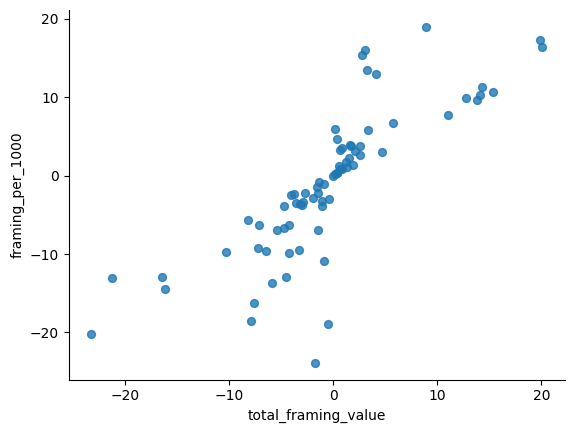

In [30]:
# @title total_framing_value vs framing_per_1000

from matplotlib import pyplot as plt
leaderboard.plot(kind='scatter', x='total_framing_value', y='framing_per_1000', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)